# Leer las ondas
1) Imports

In [1]:
%load_ext oct2py.ipython
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
#para el tiempo
from datetime import datetime
import pandas as pd
octave.addpath('/home/scidb/HeartRatePatterns/Matlab/')
octave.eval('pkg load signal')

Leer la base de datos para decidir que Ondas vamos a traer

In [2]:
def obtainWaveFormFields(dbname="mimic") :
    labels='II'
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "SELECT lef.subject_id,lef.recorddate,lef.signame,lef.fs FROM waveformfields lef  LEFT JOIN (SELECT MAX(recorddate) AS recorddate,subject_id FROM waveformFields GROUP BY subject_id) rig ON lef.subject_id = rig.subject_id AND lef.recorddate = rig.recorddate WHERE rig.subject_id IS NOT NULL AND signame @> ARRAY['"+labels+"']::varchar[]"
    cur.execute(select_stament)
    waves = []
    for row in cur :
        patient = "p"+str(row[0]).zfill(6)
        onda = patient+'-'+row[1]
        carpeta = patient[:3]+"/"+patient
        waves.append({"subject_id":row[0],"recorddate":row[1],"fs":row[3],"onda":onda,"carpeta":carpeta,
                      "signalII":row[2].index("II")})
    conn.close()
    return waves

In [3]:
waves = obtainWaveFormFields()
countWave = 0
carpeta = waves[countWave]["carpeta"]
onda = waves[countWave]["onda"]
signalII = waves[countWave]["signalII"]
fs = waves[countWave]["fs"]
subject_id = waves[countWave]["subject_id"]
recorddate = waves[countWave]["recorddate"]
print("subject_id",subject_id,"recorddate",recorddate)
signal = wfdb.rdsamp(onda,pbdir='mimic3wdb/matched/'+carpeta,channels =[signalII]).p_signals

subject_id 20 recorddate 2183-04-28-17-47


In [4]:
def updateSignal(subject_id,recorddate,signallen,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    update_stament = "UPDATE waveformfields SET signallength=(%s) WHERE subject_id = (%s) AND recorddate = (%s)"
    cur.execute(update_stament,(signallen,subject_id,recorddate))
    conn.commit()

In [5]:
def subSignal(signal) :
    signalNan = signal[~np.isnan(signal)]
    signalSize = 1800000
    print("La señal tiene ",len(signalNan)," registros extraemos las ultimas 4 horas")
    if len(signalNan)<signalSize :
        subsignal = signalNan
    else :
        subsignal = signalNan[-1800000:]
    return subsignal.tolist()

In [6]:
updateSignal(subject_id,recorddate,len(signal))
subsignal = subSignal(signal)
len(subsignal)
#subsignal[1001500:1002000]

La señal tiene  9862435  registros extraemos las ultimas 4 horas


1800000

Extraemos las ultimas 4 horas osea 1'800.000 registros

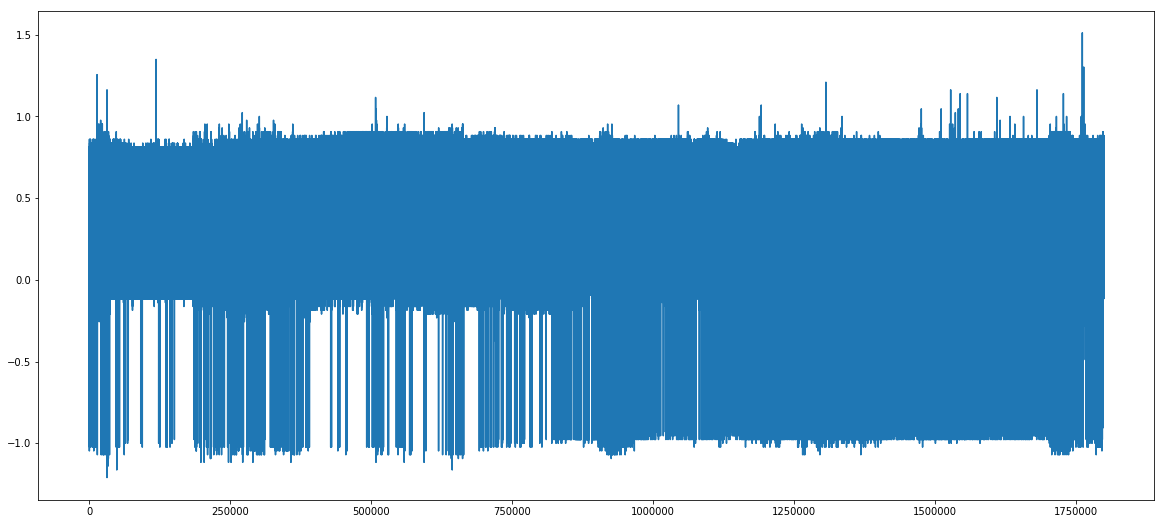

In [7]:
fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(subsignal)
#plt.plot(signal[:,1])
plt.show()

In [8]:
def peakdetect(signal, fs,increment=0,previousResult=None):
    if previousResult is None:
        previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
#    (R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot) = octave.peakdetect(signal,fs,False, nout=10)
    %octave [R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot] = peakdetect(signal,fs,false); -i signal,fs -o R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot
    return {'Q_i'  :np.concatenate((previousResult['Q_i'],  Q_i[0]+increment)),
            'Q_amp':np.concatenate((previousResult['Q_amp'],Q_amp[0])),
            'R_i'  :np.concatenate((previousResult['R_i'],  R_i[0]+increment)),
            'R_amp':np.concatenate((previousResult['R_amp'],R_amp[0])),
            'S_i'  :np.concatenate((previousResult['S_i'],  S_i[0]+increment)),
            'S_amp':np.concatenate((previousResult['S_amp'],S_amp[0])),
            'T_i'  :np.concatenate((previousResult['T_i'],  T_i[0]+increment)),
            'T_amp':np.concatenate((previousResult['T_amp'],T_amp[0])),
           }

In [11]:
windowsize = 1000*fs
suprasignal = subsignal[875000:1002000]
#print(suprasignal)
first = peakdetect(suprasignal,fs)
second = peakdetect(subsignal[windowsize:windowsize*2],fs,increment=windowsize,previousResult=first)
print(first)

{'Q_i': array([  1.50000000e+01,   1.28000000e+02,   2.40000000e+02, ...,
         1.26690000e+05,   1.26799000e+05,   1.26907000e+05]), 'T_i': array([  6.00000000e+01,   1.72000000e+02,   2.85000000e+02, ...,
         1.26734000e+05,   1.26843000e+05,   1.26951000e+05]), 'T_amp': array([ 0.06511628,  0.08837209,  0.06046512, ...,  0.09302326,
        0.09767442,  0.08372093]), 'R_amp': array([ 0.53023256,  0.52093023,  0.52093023, ...,  0.49767442,
        0.53488372,  0.51162791]), 'S_amp': array([-0.06511628, -0.06046512, -0.08372093, ..., -0.08837209,
       -0.06511628, -0.0744186 ]), 'R_i': array([  2.00000000e+01,   1.33000000e+02,   2.45000000e+02, ...,
         1.26695000e+05,   1.26804000e+05,   1.26912000e+05]), 'S_i': array([  3.30000000e+01,   1.44000000e+02,   2.58000000e+02, ...,
         1.26707000e+05,   1.26814000e+05,   1.26924000e+05]), 'Q_amp': array([-0.05581395, -0.02790698, -0.04186047, ..., -0.06046512,
       -0.05581395, -0.05116279])}


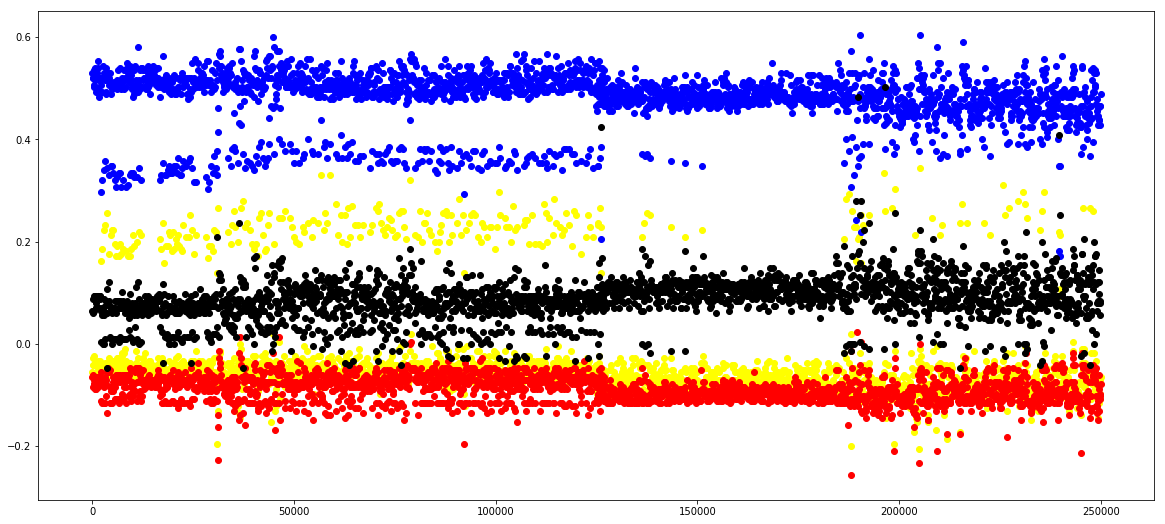

In [12]:
#plt.plot(subsignal[0:end],c='lightgreen')
plt.scatter(second['Q_i'], second['Q_amp'],c='yellow')
plt.scatter(second['R_i'], second['R_amp'],c='blue')
plt.scatter(second['S_i'], second['S_amp'],c='red')
plt.scatter(second['T_i'], second['T_amp'],c='black')
plt.show()

In [13]:
def audit(before=datetime.now()):
    now = datetime.now()
    print("hasta aqui van",(now-before))
    return now

def checkwave(signal,fs):
    now = audit()
    windowsize = 1000*fs
    signalsize = len(signal)
    previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    termino = True
    fin=0
    while termino:
        ini=fin
        fin=fin+ (windowsize)
        if(fin>signalsize):
            fin=signalsize
        now = audit(now)
        print("ini",ini,"fin",fin)
        previousResult = peakdetect(signal[ini:fin],fs,increment=ini,previousResult=previousResult)
        now = audit(now)
        termino = fin<signalsize
    return previousResult

In [14]:
previousResult = checkwave(subsignal,fs)
previousResult

hasta aqui van 0:00:00.013454
hasta aqui van 0:00:00.002896
ini 0 fin 125000


hasta aqui van 0:00:34.762889
hasta aqui van 0:00:00.000375
ini 125000 fin 250000


hasta aqui van 0:00:31.289253
hasta aqui van 0:00:00.000187
ini 250000 fin 375000


hasta aqui van 0:00:34.538552
hasta aqui van 0:00:00.000146
ini 375000 fin 500000


hasta aqui van 0:00:32.866150
hasta aqui van 0:00:00.000385
ini 500000 fin 625000


hasta aqui van 0:00:33.458145
hasta aqui van 0:00:00.000143
ini 625000 fin 750000


hasta aqui van 0:00:32.478379
hasta aqui van 0:00:00.000473
ini 750000 fin 875000


hasta aqui van 0:00:33.924581
hasta aqui van 0:00:00.000237
ini 875000 fin 1000000


hasta aqui van 0:00:33.533647
hasta aqui van 0:00:00.000569
ini 1000000 fin 1125000


hasta aqui van 0:00:34.012372
hasta aqui van 0:00:00.000604
ini 1125000 fin 1250000


hasta aqui van 0:00:33.170472
hasta aqui van 0:00:00.000377
ini 1250000 fin 1375000


hasta aqui van 0:00:36.378582
hasta aqui van 0:00:00.000443
ini 1375000 fin 1500000


hasta aqui van 0:00:34.351965
hasta aqui van 0:00:00.000767
ini 1500000 fin 1625000


hasta aqui van 0:00:33.991059
hasta aqui van 0:00:00.000500
ini 1625000 fin 1750000


hasta aqui van 0:00:34.026394
hasta aqui van 0:00:00.000647
ini 1750000 fin 1800000


hasta aqui van 0:00:10.754109


{'Q_amp': array([-0.04186047, -0.06511628, -0.10697674, ..., -0.05581395,
        -0.06511628, -0.03255814]),
 'Q_i': array([  6.00000000e+01,   1.59000000e+02,   2.59000000e+02, ...,
          1.79968500e+06,   1.79979300e+06,   1.79990100e+06]),
 'R_amp': array([ 0.48837209,  0.48837209,  0.46511628, ...,  0.54418605,
         0.51627907,  0.5255814 ]),
 'R_i': array([  6.50000000e+01,   1.64000000e+02,   2.64000000e+02, ...,
          1.79969000e+06,   1.79979800e+06,   1.79990600e+06]),
 'S_amp': array([-0.07906977, -0.09767442, -0.11627907, ..., -0.0744186 ,
        -0.06511628, -0.09767442]),
 'S_i': array([  7.60000000e+01,   1.75000000e+02,   2.75000000e+02, ...,
          1.79970100e+06,   1.79981000e+06,   1.79991800e+06]),
 'T_amp': array([ 0.10697674,  0.06511628,  0.0744186 , ...,  0.06511628,
         0.10232558,  0.05581395]),
 'T_i': array([  1.05000000e+02,   2.05000000e+02,   3.05000000e+02, ...,
          1.79973000e+06,   1.79983700e+06,   1.79994500e+06])}

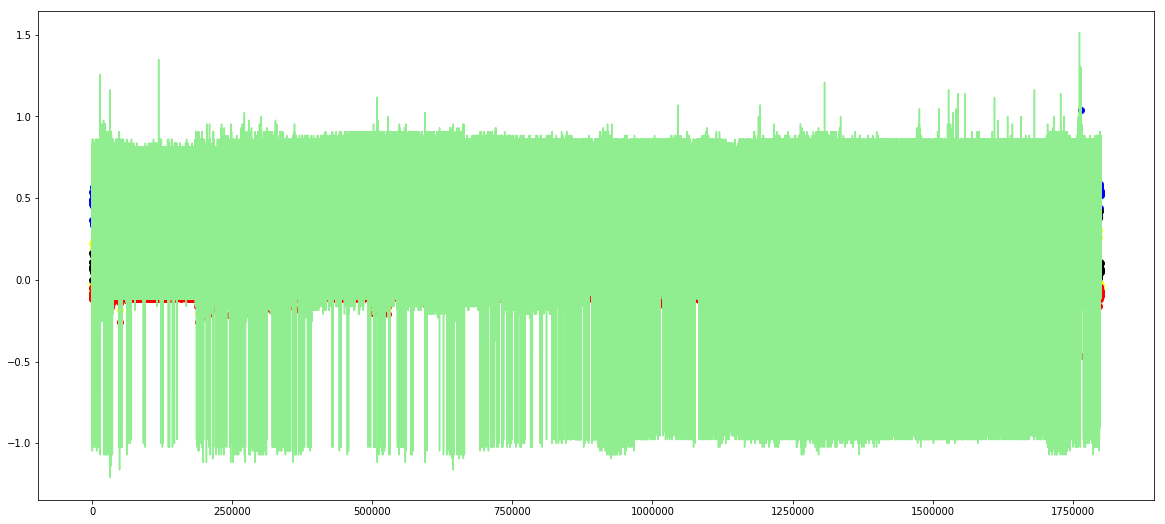

In [15]:
plt.scatter(previousResult['Q_i'], previousResult['Q_amp'],c='yellow')
plt.scatter(previousResult['R_i'], previousResult['R_amp'],c='blue')
plt.scatter(previousResult['S_i'], previousResult['S_amp'],c='red')
plt.scatter(previousResult['T_i'], previousResult['T_amp'],c='black')
plt.plot(subsignal,c='lightgreen')
plt.show()

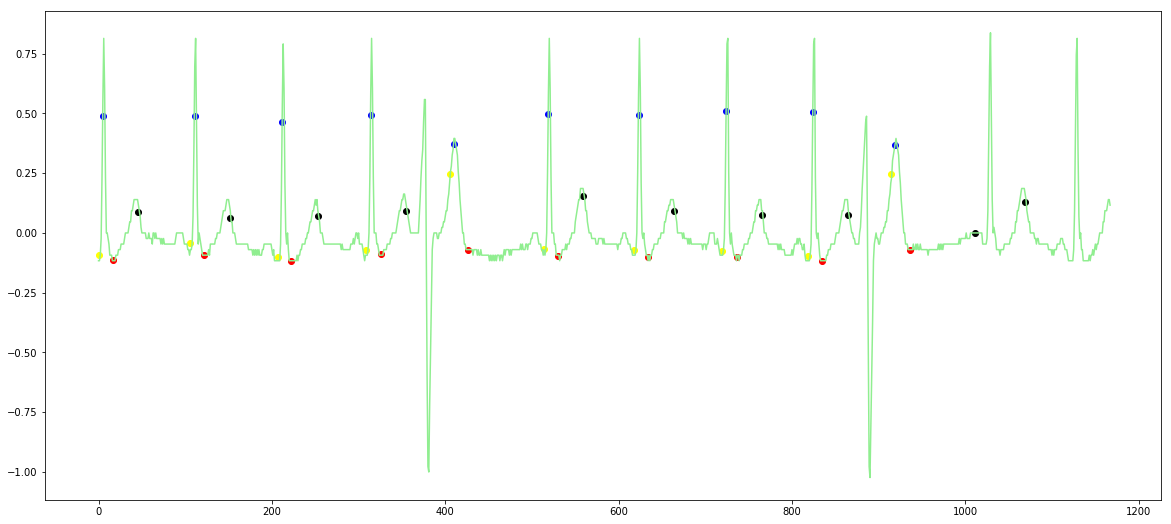

In [16]:
init = 45
end = 55
plt.plot(subsignal[int(previousResult['Q_i'][init]):int(previousResult['T_i'][end])],c='lightgreen')
plt.scatter(previousResult['Q_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['Q_amp'][init:end],c='yellow')
plt.scatter(previousResult['R_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['R_amp'][init:end],c='blue')
plt.scatter(previousResult['S_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['S_amp'][init:end],c='red')
plt.scatter(previousResult['T_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['T_amp'][init:end],c='black')
plt.show()

In [17]:
print('Q',previousResult['Q_i'][504],'R',previousResult['R_i'][504])
print('S',previousResult['S_i'][504],'T',previousResult['T_i'][504])
print('Q',previousResult['Q_i'][505],'R',previousResult['R_i'][505])
print('S',previousResult['S_i'][505],'T',previousResult['T_i'][505])
print(previousResult['T_i'][504]<previousResult['Q_i'][504])

Q 53353.0 R 53358.0
S 53369.0 T 54240.0
Q 53456.0 R 53461.0
S 53472.0 T 54346.0
False


In [18]:
print('Q',len(previousResult['Q_i']), len(previousResult['Q_amp']))
print('R',len(previousResult['R_i']), len(previousResult['R_amp']))
print('S',len(previousResult['S_i']), len(previousResult['S_amp']))
print('T',len(previousResult['T_i']), len(previousResult['T_amp']))

Q 16392 16392
R 16392 16392
S 16392 16392
T 16268 16268


In [19]:
def readsignal(qi,qinext,wave,amp,i,signal) :
    if(len(signal[wave])>i) :
        wavei,waveamp = int(signal[wave][i]),signal[amp][i]
    else :
        wavei,waveamp = None,None
    if(qinext is not None and qinext<wavei) :
        wavei,waveamp,i = None,None,i-1
    if wavei is not None and wavei<qi :
        i=i+1
        wavei,waveamp = int(signal[wave][i]),signal[amp][i]

    return wavei,waveamp,i

def sortHeartBeats(signal) :
    iterations = max(len(signal['Q_i']),len(signal['S_i']),len(signal['T_i']))
    q,s,t,result = 0,0,0,None
    while q<iterations:
        qinext = signal['Q_i'][q+1] if q+1<iterations else None
        
        qi,qamp = int(signal['Q_i'][q]),signal['Q_amp'][q]
        si,samp,s = readsignal(qi,qinext,'S_i','S_amp',s,signal)
        ti,tamp,t = readsignal(qi,qinext,'T_i','T_amp',t,signal)
                    
        if ti is not None and ti<qi :
            print("error en",q,"con t",t)
            
        dic = {'Q_i':qi,'Q_amp':qamp,
              'R_i':int(signal['R_i'][q]),'R_amp':signal['R_amp'][q],
              'S_i':si,'S_amp':samp,
              'T_i':ti,'T_amp':tamp}
        if result is None :
            result = pd.DataFrame(dic, index=[q])
        else :
            result = pd.concat([result,  pd.DataFrame(dic, index=[q])])
        q,s,t=q+1,s+1,t+1
    print("q",q,"t",t)
    return result
sortBeats = sortHeartBeats(previousResult)
print(sortBeats)

q 16392 t 16268
          Q_amp      Q_i     R_amp      R_i     S_amp      S_i     T_amp  \
0     -0.041860       60  0.488372       65 -0.079070       76  0.106977   
1     -0.065116      159  0.488372      164 -0.097674      175  0.065116   
2     -0.106977      259  0.465116      264 -0.116279      275  0.074419   
3      0.223256      354  0.367442      359 -0.093023      376  0.000000   
4     -0.023256      468  0.534884      473 -0.051163      483  0.167442   
5     -0.097674      570  0.483721      575 -0.111628      587  0.079070   
6     -0.088372      670  0.465116      675 -0.116279      685  0.093023   
7      0.223256      763  0.353488      768 -0.083721      786  0.000000   
8     -0.037209      876  0.539535      881 -0.055814      893  0.153488   
9     -0.088372      979  0.516279      984 -0.111628      995  0.065116   
10    -0.088372     1079  0.465116     1084 -0.116279     1094  0.060465   
11    -0.106977     1179  0.483721     1184 -0.116279     1195  0.093023

In [20]:
def checkQRST(qrst) :
    shape = qrst.shape[0]
    x = 0
    while x<shape :
        if(qrst.iloc[x]["S_i"] is not None and qrst.iloc[x]["S_i"]-qrst.iloc[x]["Q_i"]<0) :
            print(qrst.iloc[x]["S_i"]-qrst.iloc[x]["Q_i"])
        x=x+1
checkQRST(sortBeats)

In [21]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(np.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(np.int64, addapt_numpy_int64)

In [22]:
sortBeats = sortBeats.assign(subject_id=int(subject_id)).assign(recorddate=recorddate)
sortBeats['QRTSOrder'] = sortBeats.index
def saveQRST(qrst) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    table = "waveformQRST"
    cur.execute("CREATE TABLE IF NOT EXISTS "+table+
            " (id serial PRIMARY KEY,"+
            "Q_amp real,"+
            "Q_i integer,"+
            "R_amp real,"+
            "R_i integer,"+
            "S_amp real,"+
            "S_i integer,"+
            "T_amp real,"+
            "T_i integer,"+
            "subject_id integer,recorddate character varying(255),QRTSOrder integer,"+
            'CONSTRAINT "uniqueQRST" UNIQUE (subject_id, recorddate, qrtsorder));')
    insert_statement = 'insert into '+table+' (%s) values %s'
    for index, row in qrst.iterrows():
        columns = row.keys()
        values = [row[column] for column in columns]
#        print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
        cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    conn.close()
saveQRST(sortBeats)

IntegrityError: duplicate key value violates unique constraint "uniqueQRST"
DETAIL:  Key (subject_id, recorddate, qrtsorder)=(20, 2183-04-28-17-47, 0) already exists.


In [ ]:
def existQRST(table="waveformQRST",subject_id,recorddate):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
     select_stament = 'select id from '+table+' where subject_id= %s and recorddate = %s'
    cur.execute(select_stament,(int(subject_id),recordDate))
    exist = cur.fetchone() is None
    conn.close()
    return exist